In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pillow pillow-heif timm torchmetrics seaborn scikit-learn opencv-python


In [ ]:
import torch, os, timm
import torch.nn as nn
import numpy as np
import pandas as pd
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt


# Extracting Data & Converting to JPG

In [ ]:
import zipfile, os

zip_path = "/content/drive/MyDrive/PRDATA.zip"
extract_path = "/content/drive/MyDrive/PRDATA_UNZIPPED"

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(os.listdir(extract_path))

['Data']


In [ ]:
import os, shutil

base = "/content/drive/MyDrive/PRDATA_UNZIPPED/Data"

mapping = {
    "angry": "angry",
    "fear": "fear",
    "happy": "Happy1",
    "sad": "sad",
    "surprise": "Surprised"
}

for cls, inner in mapping.items():
    src = os.path.join(base, cls, inner)
    dst = os.path.join(base, cls)

    for f in os.listdir(src):
        shutil.move(os.path.join(src, f), dst)

    os.rmdir(src)

print("✅ Dataset structure normalized")


✅ Dataset structure normalized


In [ ]:
from PIL import Image
import pillow_heif, uuid

pillow_heif.register_heif_opener()

for cls in os.listdir(base):
    for f in os.listdir(os.path.join(base,cls)):
        path = os.path.join(base,cls,f)
        try:
            img = Image.open(path).convert("RGB")
            new = os.path.join(base,cls,f"{uuid.uuid4().hex}.jpg")
            img.save(new,"JPEG")
            os.remove(path)
        except:
            print("Skipped:",path)

In [ ]:
counts = {c:len(os.listdir(os.path.join(base,c))) for c in os.listdir(base)}
counts

{'angry': 95, 'fear': 192, 'happy': 230, 'sad': 142, 'surprise': 86}

# Building dataframe

In [ ]:
base = "/content/drive/MyDrive/PRDATA_UNZIPPED/Data"

files, labels = [], []
for c in os.listdir(base):
    for f in os.listdir(os.path.join(base,c)):
        files.append(os.path.join(base,c,f))
        labels.append(c)

df = pd.DataFrame({"file":files,"label":labels})


# Stratified split

In [ ]:
from sklearn.model_selection import train_test_split

train, temp = train_test_split(df, stratify=df.label, test_size=0.3, random_state=42)
val, test = train_test_split(temp, stratify=temp.label, test_size=0.5, random_state=42)

# Dataset

In [ ]:
class FERDataset(Dataset):
    def __init__(self,df):
        self.df=df.reset_index(drop=True)
        self.classes=sorted(df.label.unique())
        self.map={c:i for i,c in enumerate(self.classes)}
        self.tf=transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize([0.5]*3,[0.5]*3)
        ])
    def __len__(self): return len(self.df)
    def __getitem__(self,i):
        img=Image.open(self.df.file[i]).convert("RGB")
        return self.tf(img), self.map[self.df.label[i]]


# Sampler

In [ ]:
weights = 1/train.label.value_counts()
sampler = WeightedRandomSampler(train.label.map(weights).values, len(train))

train_ds, val_ds = FERDataset(train), FERDataset(val)
train_loader = DataLoader(train_ds,16,sampler=sampler)
val_loader = DataLoader(val_ds,16,shuffle=False)


# EfficientNet + SE Attention

In [ ]:
import timm
import torch.nn as nn

class SE(nn.Module):
    def __init__(self, c):
        super().__init__()
        self.fc = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(c, c//16, 1),
            nn.ReLU(),
            nn.Conv2d(c//16, c, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return x * self.fc(x)

class FERModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = timm.create_model(
            "efficientnet_b0",
            pretrained=True,
            features_only=True
        )

        # get channel size automatically
        with torch.no_grad():
            dummy = torch.zeros(1,3,224,224)
            c = self.backbone(dummy)[-1].shape[1]

        self.se = SE(c)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(c,512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512,5)
        )

    def forward(self,x):
        x = self.backbone(x)[-1]
        x = self.se(x)
        x = self.pool(x).flatten(1)
        return self.fc(x)


# Focal Loss

In [ ]:
counts = train.label.value_counts().sort_index()
w = 1/torch.tensor(counts.values,dtype=torch.float)
w = w/w.sum()

class FocalLoss(nn.Module):
    def __init__(self,w):
        super().__init__()
        self.w=w; self.g=2
    def forward(self,x,y):
        ce=nn.CrossEntropyLoss(weight=self.w)(x,y)
        pt=torch.exp(-ce)
        return ((1-pt)**self.g*ce).mean()

# Train

In [ ]:
device="cuda"
model = FERModel().to(device)
loss_fn = FocalLoss(w.to(device))
opt = torch.optim.AdamW(model.parameters(),1e-4)

train_loss_hist=[]
val_loss_hist=[]
train_f1_hist=[]
val_f1_hist=[]

for epoch in range(30):
    # TRAIN
    model.train()
    t_loss, preds, gt = 0, [], []
    for x,y in train_loader:
        x,y = x.to(device), y.to(device)
        opt.zero_grad()
        out = model(x)
        loss = loss_fn(out,y)
        loss.backward()
        opt.step()

        t_loss += loss.item()
        preds += out.argmax(1).cpu().tolist()
        gt += y.cpu().tolist()

    train_loss_hist.append(t_loss/len(train_loader))
    train_f1_hist.append(f1_score(gt,preds,average="macro"))

    # VALIDATE
    model.eval()
    v_loss, v_preds, v_gt = 0, [], []
    with torch.no_grad():
        for x,y in val_loader:
            out = model(x.to(device))
            loss = loss_fn(out,y.to(device))
            v_loss += loss.item()
            v_preds += out.argmax(1).cpu().tolist()
            v_gt += y.tolist()

    val_loss_hist.append(v_loss/len(val_loader))
    val_f1_hist.append(f1_score(v_gt,v_preds,average="macro"))

    print(f"Epoch {epoch} | Train F1 {train_f1_hist[-1]:.3f} | Val F1 {val_f1_hist[-1]:.3f}")


Epoch 0 | Train F1 0.385 | Val F1 0.353
Epoch 1 | Train F1 0.546 | Val F1 0.442
Epoch 2 | Train F1 0.704 | Val F1 0.692
Epoch 3 | Train F1 0.805 | Val F1 0.767
Epoch 4 | Train F1 0.859 | Val F1 0.863
Epoch 5 | Train F1 0.916 | Val F1 0.940
Epoch 6 | Train F1 0.962 | Val F1 0.913
Epoch 7 | Train F1 0.988 | Val F1 0.928
Epoch 8 | Train F1 0.975 | Val F1 0.938
Epoch 9 | Train F1 0.984 | Val F1 0.942
Epoch 10 | Train F1 0.986 | Val F1 0.944
Epoch 11 | Train F1 0.985 | Val F1 0.955
Epoch 12 | Train F1 0.987 | Val F1 0.944
Epoch 13 | Train F1 0.989 | Val F1 0.955
Epoch 14 | Train F1 0.987 | Val F1 0.952
Epoch 15 | Train F1 0.990 | Val F1 0.950
Epoch 16 | Train F1 0.998 | Val F1 0.952
Epoch 17 | Train F1 0.994 | Val F1 0.963
Epoch 18 | Train F1 0.994 | Val F1 0.952
Epoch 19 | Train F1 0.983 | Val F1 0.952
Epoch 20 | Train F1 0.989 | Val F1 0.932


KeyboardInterrupt: 

# Save the trained model

In [ ]:
save_path = "/content/drive/MyDrive/FER_best_model.pth"

torch.save({
    "model_state_dict": model.state_dict(),
    "classes": train_ds.classes,
    "train_f1": train_f1_hist,
    "val_f1": val_f1_hist,
    "train_loss": train_loss_hist,
    "val_loss": val_loss_hist
}, save_path)

print("Model saved to:", save_path)


Model saved to: /content/drive/MyDrive/FER_best_model.pth


############################ VISUALIZATIONS ############################

# Training vs Validation Curves

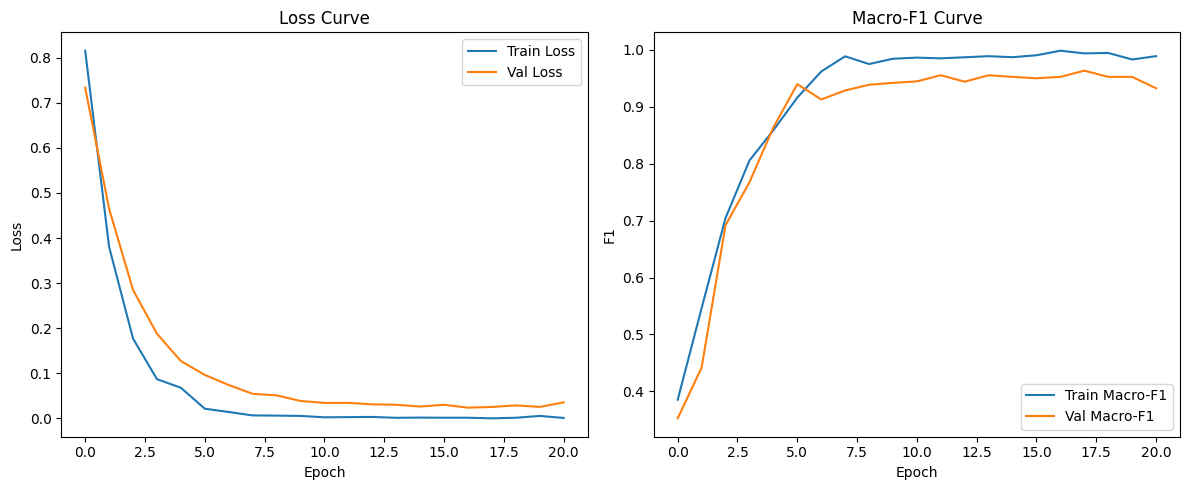

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_loss_hist, label="Train Loss")
plt.plot(val_loss_hist, label="Val Loss")
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_f1_hist, label="Train Macro-F1")
plt.plot(val_f1_hist, label="Val Macro-F1")
plt.title("Macro-F1 Curve")
plt.xlabel("Epoch")
plt.ylabel("F1")
plt.legend()

plt.tight_layout()
plt.show()


# Confusion Matrix

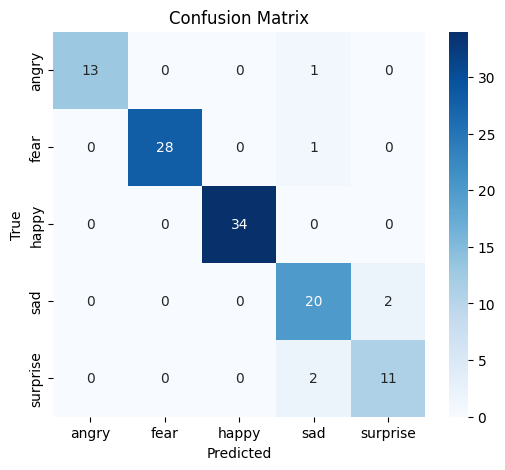

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(v_gt, v_preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=train_ds.classes,
            yticklabels=train_ds.classes,
            cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Per-Class Performance

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(v_gt, v_preds, target_names=train_ds.classes))

              precision    recall  f1-score   support

       angry       1.00      0.93      0.96        14
        fear       1.00      0.97      0.98        29
       happy       1.00      1.00      1.00        34
         sad       0.83      0.91      0.87        22
    surprise       0.85      0.85      0.85        13

    accuracy                           0.95       112
   macro avg       0.94      0.93      0.93       112
weighted avg       0.95      0.95      0.95       112



# Testing

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

checkpoint = torch.load("/content/drive/MyDrive/FER_best_model.pth", map_location=device)

model = FERModel().to(device)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

class_names = checkpoint["classes"]

print("Loaded classes:", class_names)


Loaded classes: ['angry', 'fear', 'happy', 'sad', 'surprise']


In [ ]:
from torchvision import transforms
from PIL import Image
import pillow_heif

pillow_heif.register_heif_opener()

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])


In [ ]:
def predict_image(image_path):
    img = Image.open(image_path).convert("RGB")
    x = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        out = model(x)
        probs = torch.softmax(out, dim=1)[0]
        pred = probs.argmax().item()

    return class_names[pred], probs.cpu().numpy()


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving images (1).jpeg to images (1).jpeg


In [ ]:
for fname in uploaded.keys():
    label, probs = predict_image(fname)
    print(f"\nImage: {fname}")
    print("Predicted emotion:", label)
    print("Probabilities:", probs)


Image: images (1).jpeg
Predicted emotion: sad
Probabilities: [0.17395186 0.21886966 0.15796475 0.24761407 0.20159976]
